In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import numpy as np
from sklearn.metrics import f1_score, jaccard_score
import time

In [6]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset_train = VOCSegmentation(root="./data", year='2012', image_set='train', download=True, transform=transform, target_transform=transform)
dataset_val = VOCSegmentation(root="./data", year='2012', image_set='val', download=True, transform=transform, target_transform=transform)
train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=8, shuffle=False)

100%|██████████| 2.00G/2.00G [55:22<00:00, 602kB/s]    


In [25]:
class SegNet(nn.Module):
    def __init__(self, backbone='vgg'):
        super(SegNet, self).__init__()
        if backbone == 'vgg':
            vgg = models.vgg16(pretrained=True)
            self.encoder = vgg.features
            dec_channels = [512, 256, 128, 64, 32]
        elif backbone == 'efficientnet':
            effnet = models.efficientnet_b0(pretrained=True)
            self.encoder = nn.Sequential(*list(effnet.children())[:-2])
            dec_channels = [1280, 640, 320, 160, 80]

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dec_channels[0], dec_channels[1], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(dec_channels[1]),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(dec_channels[1], dec_channels[2], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(dec_channels[2]),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(dec_channels[2], dec_channels[3], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(dec_channels[3]),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(dec_channels[3], dec_channels[4], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(dec_channels[4]),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(dec_channels[4], 21, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        self.upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.upsample(x)
        return x


In [36]:
def dice_score_multiclass(y_true, y_pred, num_classes=21):
    return f1_score(y_true, y_pred, average='macro', zero_division=1)

In [27]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_pixels = 0, 0, 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = torch.argmax(outputs, dim=1)
        total_correct += (pred == masks).sum().item()
        total_pixels += masks.numel()

    return total_loss / len(loader), total_correct / total_pixels

In [28]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_pixels = 0, 0, 0
    iou_scores, f1_scores, dice_scores = [], [], []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.squeeze(1).long()

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            pred = torch.argmax(outputs, dim=1)
            total_correct += (pred == masks).sum().item()
            total_pixels += masks.numel()

            y_true = masks.cpu().numpy().flatten()
            y_pred = pred.cpu().numpy().flatten()

            iou_scores.append(jaccard_score(y_true, y_pred, average='macro', zero_division=1))
            f1_scores.append(f1_score(y_true, y_pred, average='macro', zero_division=1))
            dice_scores.append(dice_score_multiclass(y_true, y_pred, num_classes=21))

    val_loss = total_loss / len(loader) if len(loader) > 0 else 0
    val_acc = total_correct / total_pixels if total_pixels > 0 else 0
    val_iou = np.mean(iou_scores) if iou_scores else 0
    val_f1 = np.mean(f1_scores) if f1_scores else 0
    val_dice = np.mean(dice_scores) if dice_scores else 0

    return val_loss, val_acc, val_iou, val_f1, val_dice

In [29]:
# Setup and train
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model_vgg = SegNet("vgg").to(device)
model_eff = SegNet("efficientnet").to(device)
results = {}

In [30]:
optimizer = optim.Adam(model_vgg.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
start_time = time.time()
for epoch in range(15):
    train_loss, train_acc = train(model_vgg, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_iou, val_f1, val_dice = evaluate(model_vgg, val_loader, criterion, device)
    print(f"VGG: Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}, IOU {val_iou:.4f}, F1 {val_f1:.4f}, Dice {val_dice:.4f}")
results["VGG"] = {"time": time.time() - start_time, "accuracy": val_acc, "iou": val_iou, "f1": val_f1, "dice": val_dice}


VGG: Epoch 1: Train Loss 0.7382, Train Acc 0.9113, Val Loss 0.2556, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
VGG: Epoch 2: Train Loss 0.2317, Train Acc 0.9451, Val Loss 0.2330, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
VGG: Epoch 3: Train Loss 0.2193, Train Acc 0.9451, Val Loss 0.2177, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
VGG: Epoch 4: Train Loss 0.2133, Train Acc 0.9451, Val Loss 0.2102, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
VGG: Epoch 5: Train Loss 0.2081, Train Acc 0.9451, Val Loss 0.2116, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
VGG: Epoch 6: Train Loss 0.2052, Train Acc 0.9451, Val Loss 0.2114, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
VGG: Epoch 7: Train Loss 0.2021, Train Acc 0.9451, Val Loss 0.2035, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
VGG: Epoch 8: Train Loss 0.2009, Train Acc 0.9451, Val Loss 0.1997, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
VGG: Epoch 9: Train Loss 0.1994, Train Acc 0.945

In [31]:
optimizer = optim.Adam(model_eff.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
start_time = time.time()
for epoch in range(15):
    train_loss, train_acc = train(model_eff, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_iou, val_f1, val_dice = evaluate(model_eff, val_loader, criterion, device)
    print(f"Eff: Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}, IOU {val_iou:.4f}, F1 {val_f1:.4f}, Dice {val_dice:.4f}")
results["Eff"] = {"time": time.time() - start_time, "accuracy": val_acc, "iou": val_iou, "f1": val_f1, "dice": val_dice}


Eff: Epoch 1: Train Loss 0.4678, Train Acc 0.9199, Val Loss 0.2034, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
Eff: Epoch 2: Train Loss 0.1970, Train Acc 0.9451, Val Loss 0.1958, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
Eff: Epoch 3: Train Loss 0.1868, Train Acc 0.9451, Val Loss 0.1895, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
Eff: Epoch 4: Train Loss 0.1825, Train Acc 0.9450, Val Loss 0.1875, Val Acc 0.9447, IOU 0.4725, F1 0.4858, Dice 0.0463
Eff: Epoch 5: Train Loss 0.1721, Train Acc 0.9449, Val Loss 0.1954, Val Acc 0.9442, IOU 0.4758, F1 0.4923, Dice 0.0469
Eff: Epoch 6: Train Loss 0.1646, Train Acc 0.9448, Val Loss 0.1885, Val Acc 0.9427, IOU 0.4768, F1 0.4954, Dice 0.0472
Eff: Epoch 7: Train Loss 0.1556, Train Acc 0.9457, Val Loss 0.1914, Val Acc 0.9432, IOU 0.4735, F1 0.4887, Dice 0.0465
Eff: Epoch 8: Train Loss 0.1503, Train Acc 0.9465, Val Loss 0.1895, Val Acc 0.9426, IOU 0.4742, F1 0.4904, Dice 0.0467
Eff: Epoch 9: Train Loss 0.1452, Train Acc 0.947

In [32]:
for name, res in results.items():
    print(f"{name.upper()} - Time: {res['time']:.2f}s, Accuracy: {res['accuracy']:.4f}, IOU: {res['iou']:.4f}, F1: {res['f1']:.4f}, Dice: {res['dice']:.4f}")


VGG - Time: 3952.30s, Accuracy: 0.9447, IOU: 0.4725, F1: 0.4858, Dice: 0.0463
EFF - Time: 4202.24s, Accuracy: 0.9443, IOU: 0.4742, F1: 0.4895, Dice: 0.0466


In [33]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def generate_segmentation_masks(model, loader, device, num_samples=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.squeeze(1).long()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.shape[0]):
                if images_shown >= num_samples:
                    return
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))

                ax[0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
                ax[0].set_title("Original Image")
                ax[0].axis("off")

                ax[1].imshow(masks[i].cpu().numpy(), cmap=cm.get_cmap('tab20b', 21)) # Or 'viridis', 'plasma' etc.

                ax[1].set_title("Ground Truth Mask")
                ax[1].axis("off")

                ax[2].imshow(preds[i].cpu().numpy(), cmap=cm.get_cmap('tab20b', 21))
                ax[2].set_title("Predicted Mask")
                ax[2].axis("off")

                plt.show()
                images_shown += 1

/var/folders/6w/f1rjj20d7rnfn772y3xq15rc0000gn/T/ipykernel_3229/505377810.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax[1].imshow(masks[i].cpu().numpy(), cmap=cm.get_cmap('tab20b', 21)) # Or 'viridis', 'plasma' etc.
/var/folders/6w/f1rjj20d7rnfn772y3xq15rc0000gn/T/ipykernel_3229/505377810.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax[2].imshow(preds[i].cpu().numpy(), cmap=cm.get_cmap('tab20b', 21))


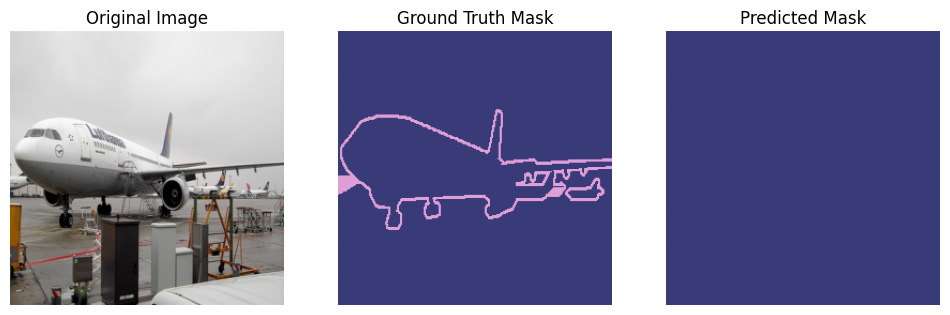

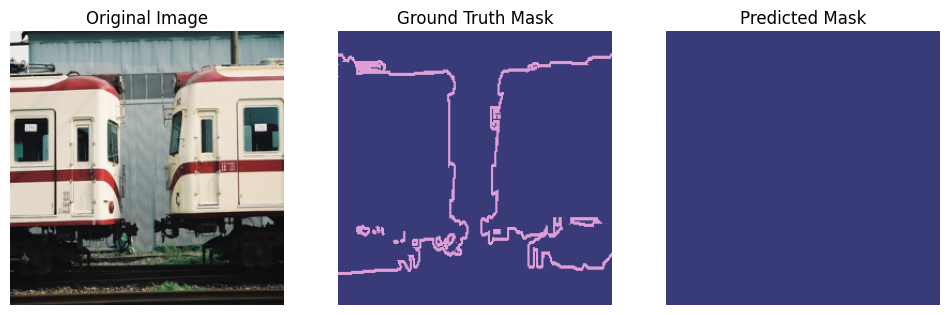

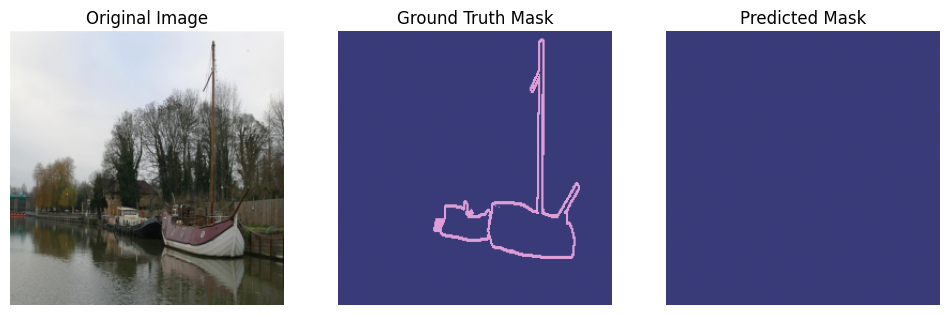

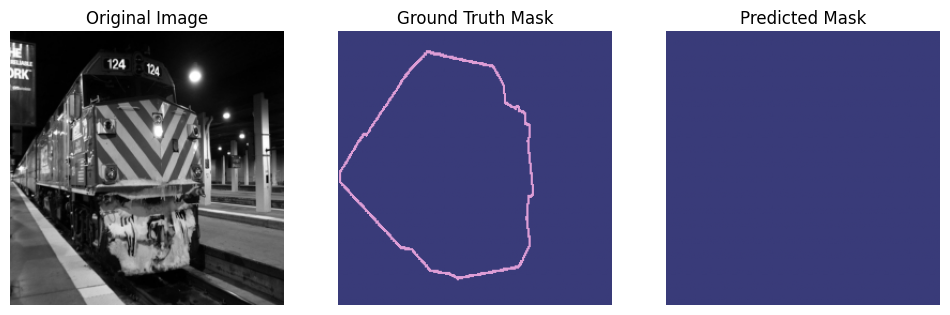

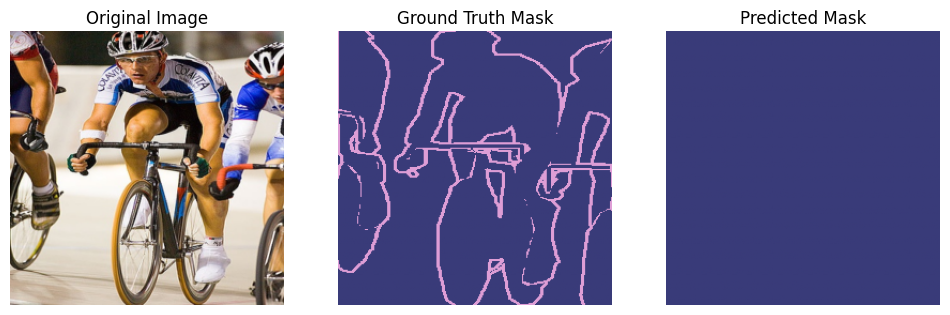

In [34]:
generate_segmentation_masks(model_vgg, val_loader, device)

/var/folders/6w/f1rjj20d7rnfn772y3xq15rc0000gn/T/ipykernel_3229/505377810.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax[1].imshow(masks[i].cpu().numpy(), cmap=cm.get_cmap('tab20b', 21)) # Or 'viridis', 'plasma' etc.
/var/folders/6w/f1rjj20d7rnfn772y3xq15rc0000gn/T/ipykernel_3229/505377810.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax[2].imshow(preds[i].cpu().numpy(), cmap=cm.get_cmap('tab20b', 21))


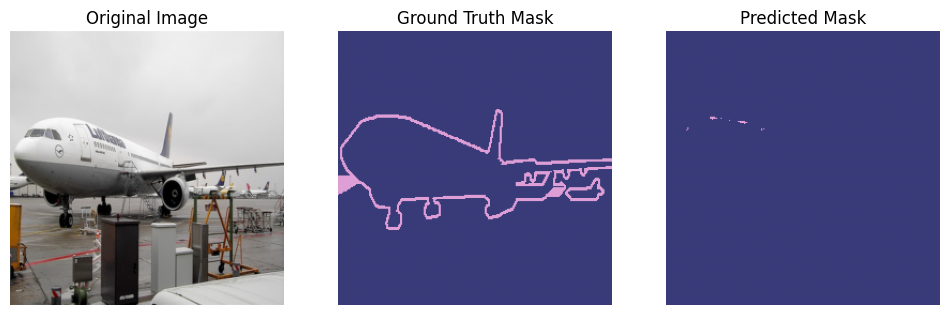

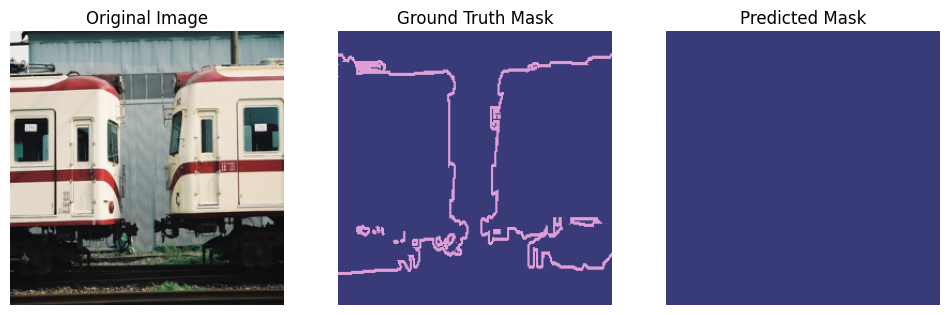

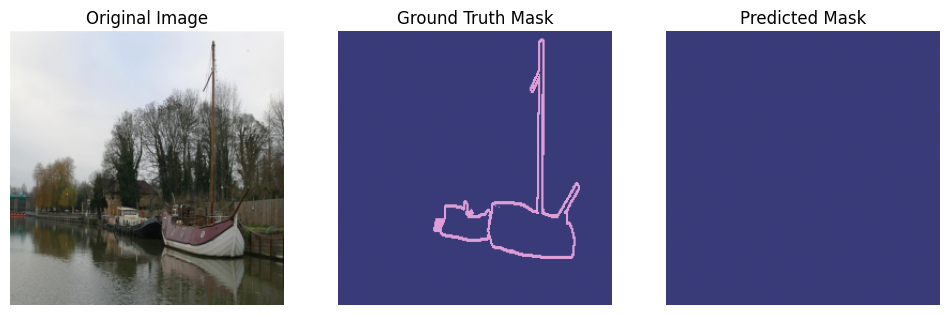

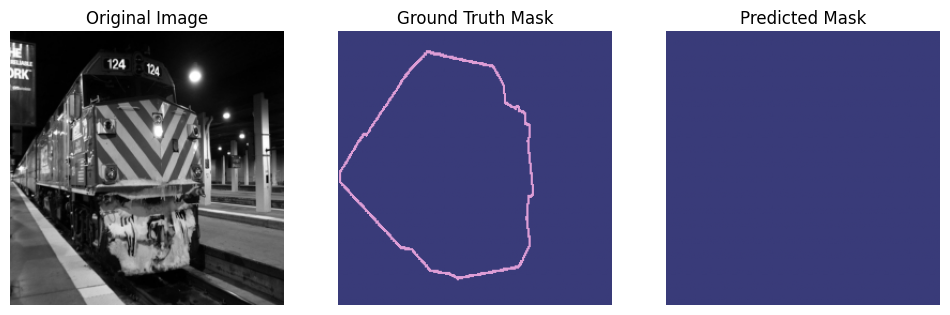

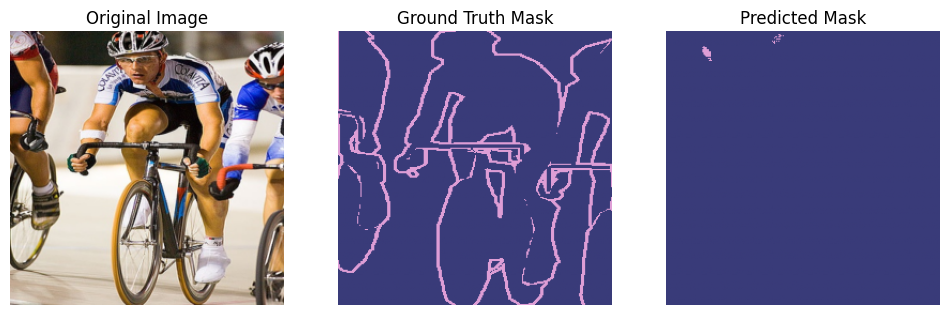

In [35]:
generate_segmentation_masks(model_eff, val_loader, device)